- Developed a machine learning model to predict the hourly taxi passenger count.
- The model takes **both the zone_id and time as input.**
- xgboost algorithm was used, its optimal parameters were determined using Hyperparameter Optimization study with Optuna.
- next step is to include the taxi subway ridership!

Results:
- Root Mean Squared Error (RMSE): 27.93
- R-squared (R2): 0.98
- Relative RMSE (as a percentage of mean): 18.34%
- Relative RMSE (as a percentage of median): 34.92%


In [1]:
import json
from shapely.geometry import shape, Point
import os
!pip install python-dotenv
from dotenv import load_dotenv
import geopandas as gpd
import pandas as pd
import numpy as np
import seaborn as sns
!pip install optuna
import optuna
import folium
from folium.plugins import HeatMap
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import xgboost as xgb
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 22.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.9 MB/s eta 0:00:00


In [9]:
load_dotenv('/content/.env')

True

In [ ]:
# Download the file from Google Drive using the file ID
!gdown {os.getenv('taxi-geojason')}
!gdown {os.getenv('cleaned-subway-data')}
!gdown {os.getenv('cleaned-taxi-data')}

In [11]:
#load the taxi dataset into a df
taxi_df = pd.read_csv('/content/combined_taxi_df.csv')

taxi_df.head()

,datetime_formatted,hour,day_of_week,week,month,day_of_month,year_month,zone,passenger_count
0,2021-01-01 00:00:00,0,4,53,0,1,2021-01,4,4
1,2021-01-01 00:00:00,0,4,53,0,1,2021-01,13,3
2,2021-01-01 00:00:00,0,4,53,0,1,2021-01,24,3
3,2021-01-01 00:00:00,0,4,53,0,1,2021-01,41,12
4,2021-01-01 00:00:00,0,4,53,0,1,2021-01,42,2


In [12]:
#drop all columns except of datetime_formated and passenger_count
taxi_df = taxi_df[["datetime_formatted", "zone", "passenger_count"]].reset_index(drop=True)

In [13]:
#rename datetime_formatted to transit_timestamp
taxi_df.rename(columns={'datetime_formatted': 'transit_timestamp', 'zone': 'zone_id' }, inplace=True)

In [14]:
taxi_df.head()

,transit_timestamp,zone_id,passenger_count
0,2021-01-01 00:00:00,4,4
1,2021-01-01 00:00:00,13,3
2,2021-01-01 00:00:00,24,3
3,2021-01-01 00:00:00,41,12
4,2021-01-01 00:00:00,42,2


In [15]:
#get the number of rows after grouping
taxi_df.shape

(1745586, 3)

In [16]:
taxi_df.dtypes

transit_timestamp    object
zone_id               int64
passenger_count       int64
dtype: object

In [17]:
#what is the max and min dates in the df
print(taxi_df['transit_timestamp'].min())
print(taxi_df['transit_timestamp'].max())

2021-01-01 00:00:00
2024-04-01 00:00:00


In [18]:
df = taxi_df.copy()

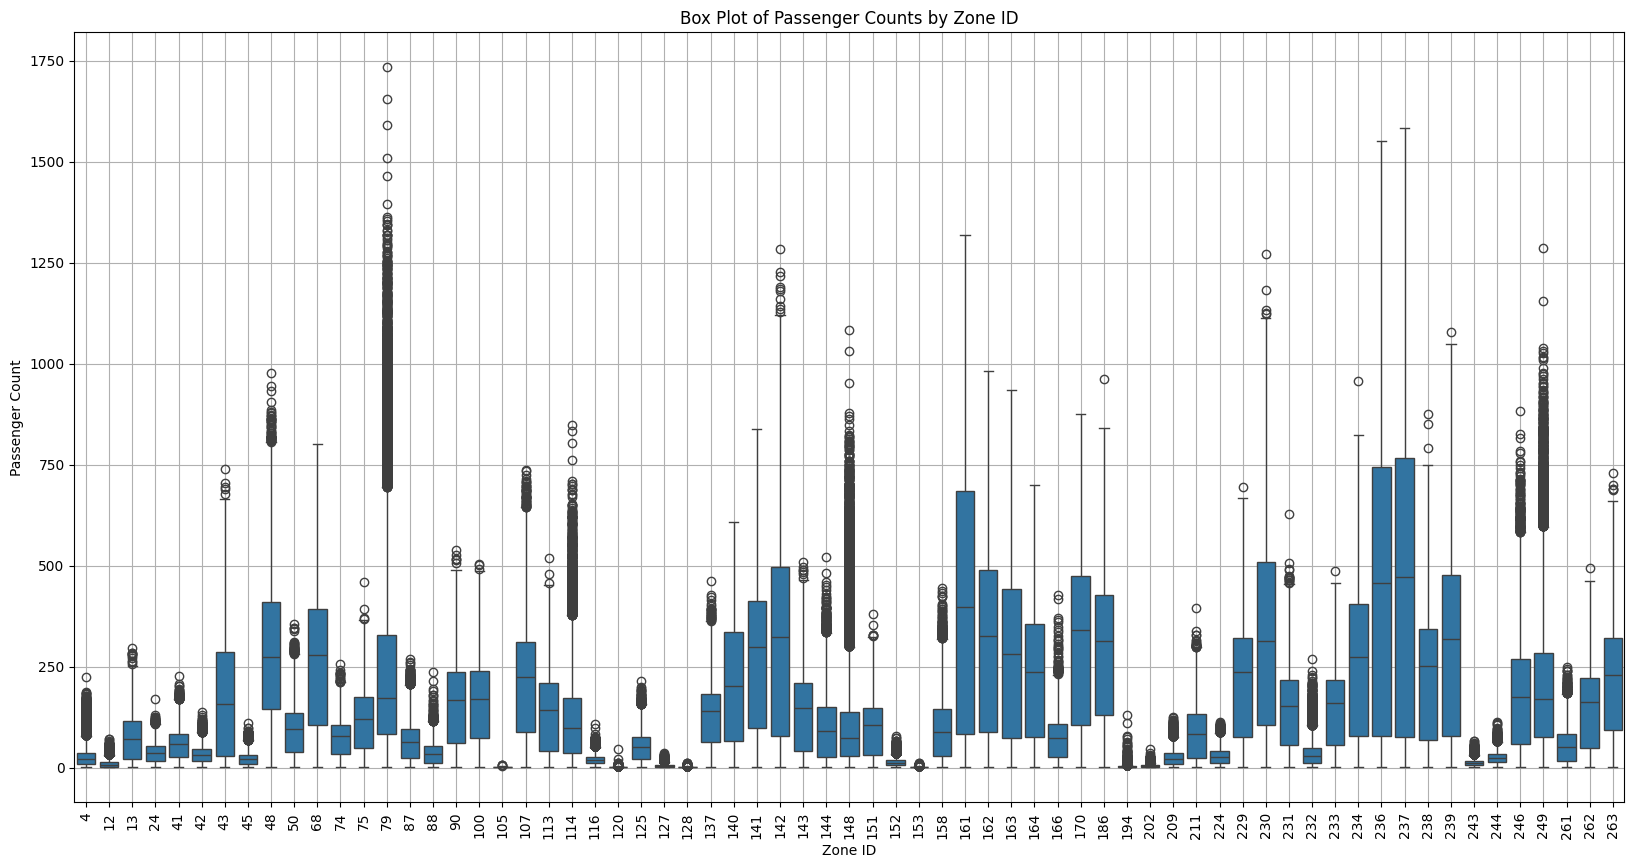

In [19]:

# Box Plot of Passenger Counts by Zone ID
plt.figure(figsize=(20, 10))
sns.boxplot(x='zone_id', y='passenger_count', data=df)
plt.xticks(rotation=90)
plt.title('Box Plot of Passenger Counts by Zone ID')
plt.xlabel('Zone ID')
plt.ylabel('Passenger Count')
plt.grid(True)
plt.show()


# # Facet Grid of Histograms by Zone ID
# g = sns.FacetGrid(df, col="zone_id", col_wrap=4, height=4)
# g.map(sns.histplot, "passenger_count", bins=20)
# g.set_titles("{col_name}")
# g.set_axis_labels("Passenger Count", "Frequency")
# plt.show()


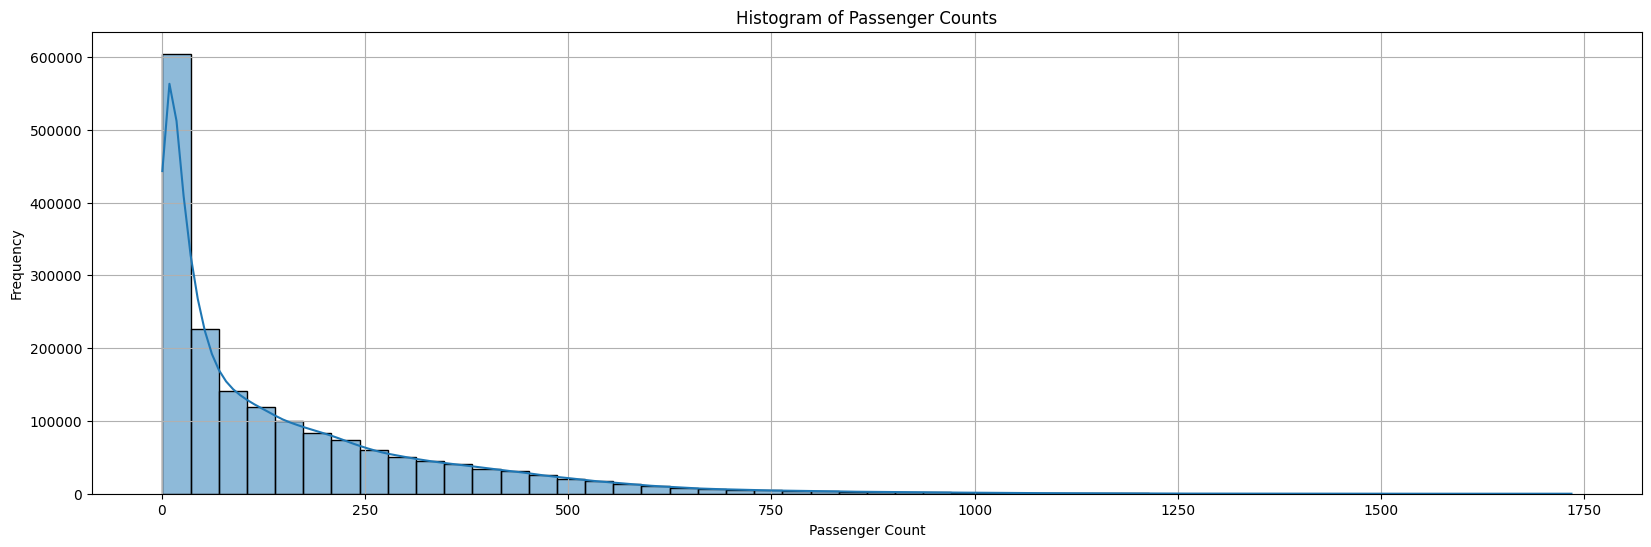

In [20]:
# Histogram of Passenger Counts
plt.figure(figsize=(20, 6))
sns.histplot(df['passenger_count'], bins=50, kde=True)
plt.title('Histogram of Passenger Counts')
plt.xlabel('Passenger Count')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()



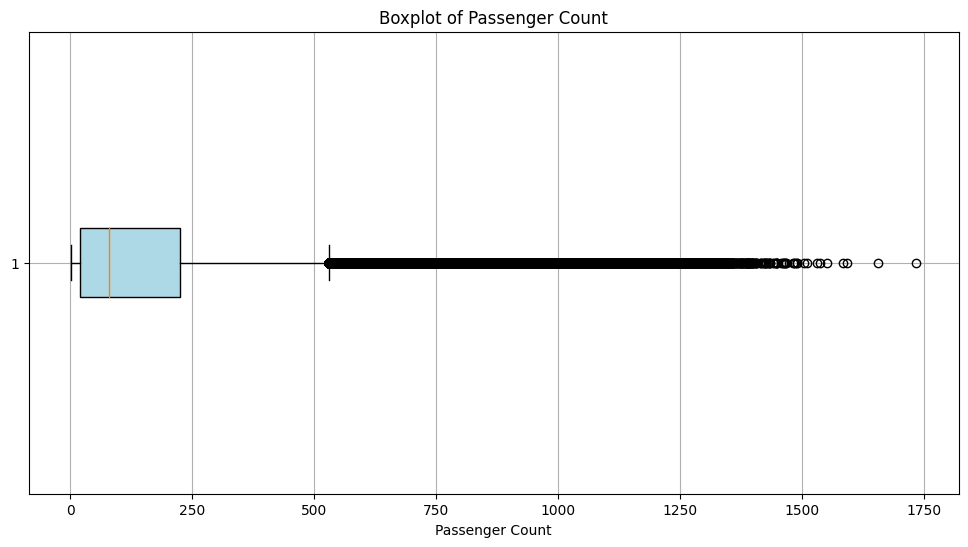

In [21]:
# Plot the boxplot of the passenger count
plt.figure(figsize=(12, 6))
plt.boxplot(df['passenger_count'], vert=False, patch_artist=True, boxprops=dict(facecolor='lightblue'))
plt.title('Boxplot of Passenger Count')
plt.xlabel('Passenger Count')
plt.grid(True)
plt.show()

In [22]:
# change the transit_timestamp into a datetime object
df['transit_timestamp'] = pd.to_datetime(df['transit_timestamp'])


In [23]:
#chack new types now
df.dtypes

transit_timestamp    datetime64[ns]
zone_id                       int64
passenger_count               int64
dtype: object

In [24]:
df.head()

,transit_timestamp,zone_id,passenger_count
0,2021-01-01,4,4
1,2021-01-01,13,3
2,2021-01-01,24,3
3,2021-01-01,41,12
4,2021-01-01,42,2


In [25]:
#count the number of unique zone_id
df['zone_id'].nunique()

67

In [26]:
# Create time-based features
df['hour'] = df['transit_timestamp'].dt.hour
df['day'] = df['transit_timestamp'].dt.day
df['weekday'] = df['transit_timestamp'].dt.weekday
df['month'] = df['transit_timestamp'].dt.month
df['year'] = df['transit_timestamp'].dt.year
df['week'] = df['transit_timestamp'].dt.isocalendar().week
df['is_weekend'] = df['weekday'] >= 5
df['is_rush_hour'] = df['hour'].isin([7, 8, 9, 16, 17, 18, 19]) & ~df['is_weekend']

# Define the range of years in the dataset
min_year = df['year'].min()
max_year = df['year'].max()

# Create cyclic features for hour, month, week, and year
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
df['week_sin'] = np.sin(2 * np.pi * df['week'] / 52)
df['week_cos'] = np.cos(2 * np.pi * df['week'] / 52)
df['year_sin'] = np.sin(2 * np.pi * (df['year'] - min_year) / (max_year - min_year + 1))
df['year_cos'] = np.cos(2 * np.pi * (df['year'] - min_year) / (max_year - min_year + 1))

# Create rolling statistics features
df['rolling_mean_24h'] = df.groupby('zone_id')['passenger_count'].transform(lambda x: x.shift(1).rolling(window=24).mean())
df['rolling_std_24h'] = df.groupby('zone_id')['passenger_count'].transform(lambda x: x.shift(1).rolling(window=24).std())
df['rolling_mean_7d'] = df.groupby('zone_id')['passenger_count'].transform(lambda x: x.shift(1).rolling(window=24*7).mean())
df['rolling_std_7d'] = df.groupby('zone_id')['passenger_count'].transform(lambda x: x.shift(1).rolling(window=24*7).std())

# Create lag features
df['lag_1h'] = df.groupby('zone_id')['passenger_count'].shift(1)
df['lag_24h'] = df.groupby('zone_id')['passenger_count'].shift(24)
df['lag_7d'] = df.groupby('zone_id')['passenger_count'].shift(24*7)

# Fill any remaining NaN values
df.fillna(method='bfill', inplace=True)

In [ ]:
# Define features and target
features = ['hour_sin', 'hour_cos', 'month_sin', 'month_cos', 'week_sin', 'week_cos', 'year_sin', 'year_cos',
            'weekday', 'is_weekend', "is_rush_hour" ,'rolling_mean_24h', 'rolling_std_24h',
            'rolling_mean_7d', 'rolling_std_7d', 'lag_1h', 'lag_24h', 'lag_7d']
X = df[features + ['zone_id']]
y = df['passenger_count']


# Initialize KFold cross-validation
kf = KFold(n_splits=10, shuffle=False)

# Define the objective function for Optuna
def objective(trial):
    # Suggest hyperparameters
    params = {
        'objective': 'reg:squarederror',
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.5),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
        'random_state': 42
    }

    mse_list = []

    # Loop through each fold
    for train_index, test_index in kf.split(X):
        # Split the data into training and testing sets for this fold
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Initialize the scaler and scale the data
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # Initialize the XGBoost regressor
        xgb_regressor = xgb.XGBRegressor(**params)

        # Fit the model
        xgb_regressor.fit(X_train_scaled, y_train)

        # Predictions
        y_pred = xgb_regressor.predict(X_test_scaled)

        # Calculate performance metrics
        mse = mean_squared_error(y_test, y_pred)
        mse_list.append(mse)

    # Return the average MSE over all folds
    return np.mean(mse_list)

# Set up the Optuna study
study = optuna.create_study(direction='minimize')

# Run the optimization
study.optimize(objective, n_trials=50)

# Print the best parameters
print('Best hyperparameters:', study.best_params)

# Best parameters found by Optuna
best_params = study.best_params

# Evaluate the best model with the found parameters
mse_list = []
rmse_list = []
r2_list = []

# Loop through each fold
for train_index, test_index in kf.split(X):
    # Split the data into training and testing sets for this fold
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Initialize the scaler and scale the data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Initialize the XGBoost regressor with the best hyperparameters
    xgb_regressor = xgb.XGBRegressor(**best_params)

    # Fit the model
    xgb_regressor.fit(X_train_scaled, y_train)

    # Predictions
    y_pred = xgb_regressor.predict(X_test_scaled)

    # Calculate performance metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    mse_list.append(mse)
    rmse_list.append(rmse)
    r2_list.append(r2)

# Print average metrics across all folds
print(f'Average Mean Squared Error (MSE): {np.mean(mse_list):.2f}')
print(f'Average Root Mean Squared Error (RMSE): {np.mean(rmse_list):.2f}')
print(f'Average R-squared (R2): {np.mean(r2_list):.2f}')

# Calculate the residuals for the last fold
residuals = y_test - y_pred

# Calculate the absolute errors
absolute_errors = np.abs(residuals)

# Find the number of predictions within 20 units of the true value
within_20 = np.sum(absolute_errors <= 20)

# Calculate the percentage of such predictions
percentage_within_20 = within_20 / len(y_test) * 100

print(f"Percentage of predictions within 20 of the true value: {percentage_within_20:.2f}%")


[I 2024-06-29 18:40:23,321] A new study created in memory with name: no-name-ad979b61-9ede-4949-883a-6fbe1bfa880e
[I 2024-06-29 18:42:40,243] Trial 0 finished with value: 1005.16148758151 and parameters: {'n_estimators': 242, 'learning_rate': 0.1431192791042337, 'max_depth': 4, 'subsample': 0.8801054065065963, 'colsample_bytree': 0.6276181972404897, 'min_child_weight': 1, 'reg_alpha': 0.4415601382804212, 'reg_lambda': 0.9883469802166011}. Best is trial 0 with value: 1005.16148758151.
[I 2024-06-29 18:45:03,165] Trial 1 finished with value: 1180.7251074545807 and parameters: {'n_estimators': 299, 'learning_rate': 0.056272978974758185, 'max_depth': 3, 'subsample': 0.7697268888007666, 'colsample_bytree': 0.6212053796881878, 'min_child_weight': 1, 'reg_alpha': 0.44482727345791995, 'reg_lambda': 0.8410453497074039}. Best is trial 0 with value: 1005.16148758151.
[I 2024-06-29 18:46:45,839] Trial 2 finished with value: 887.1034726751457 and parameters: {'n_estimators': 123, 'learning_rate': 0

Best hyperparameters: {'n_estimators': 362, 'learning_rate': 0.12912411467580226, 'max_depth': 10, 'subsample': 0.9620454248709411, 'colsample_bytree': 0.8287274232003768, 'min_child_weight': 5, 'reg_alpha': 0.23532591326140717, 'reg_lambda': 0.4725786342513321}
Average Mean Squared Error (MSE): 790.83
Average Root Mean Squared Error (RMSE): 28.04
Average R-squared (R2): 0.97
Percentage of predictions within 20 of the true value: 72.20%


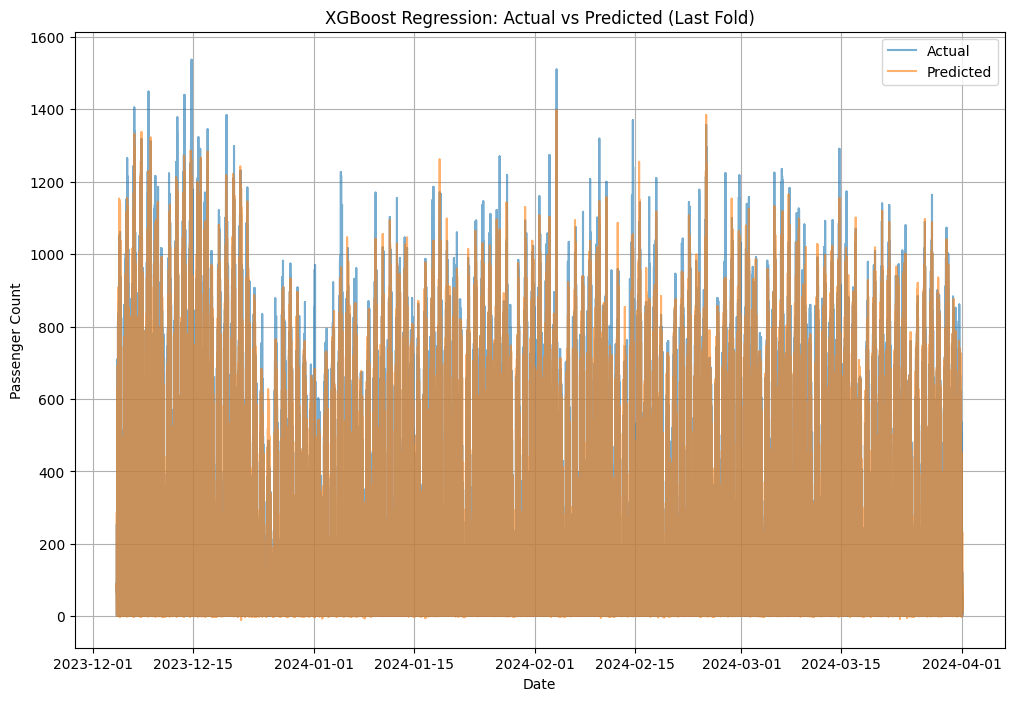

Average Mean Squared Error (MSE): 785.13
Average Root Mean Squared Error (RMSE): 27.93
Average R-squared (R2): 0.98


In [27]:
# Define features and target
features = ['hour_sin', 'hour_cos', 'month_sin', 'month_cos', 'week_sin', 'week_cos', 'year_sin', 'year_cos',
            'weekday', 'is_weekend', "is_rush_hour" ,'rolling_mean_24h', 'rolling_std_24h',
            'rolling_mean_7d', 'rolling_std_7d', 'lag_1h', 'lag_24h', 'lag_7d']
X = df[features + ['zone_id']]
y = df['passenger_count']

# One-hot encode the 'zone_id' feature
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), features),
        ('cat', OneHotEncoder(), ['zone_id'])
    ])


# Create a pipeline that scales features and trains the model
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', xgb.XGBRegressor(
        objective='reg:squarederror',
        n_estimators=362,
        learning_rate=0.12912411467580226,
        max_depth=10,
        subsample=0.9620454248709411,
        colsample_bytree=0.8287274232003768,
        min_child_weight=5,
        reg_alpha=0.23532591326140717,
        reg_lambda=0.4725786342513321,
        random_state=42))
])

# Initialize KFold cross-validation
kf = KFold(n_splits=10, shuffle=False)

# Arrays to store performance metrics for each fold
mse_list = []
rmse_list = []
r2_list = []

# Loop through each fold
for train_index, test_index in kf.split(X):
    # Split the data into training and testing sets for this fold
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Fit the pipeline
    pipeline.fit(X_train, y_train)

    # Predictions
    y_pred = pipeline.predict(X_test)

    # Calculate performance metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    mse_list.append(mse)
    rmse_list.append(rmse)
    r2_list.append(r2)

    # Plotting predictions vs actual for the last fold
    if len(mse_list) == kf.get_n_splits():
        plt.figure(figsize=(12, 8))
        plt.plot(df['transit_timestamp'].iloc[test_index], y_test, label='Actual', alpha=0.6)
        plt.plot(df['transit_timestamp'].iloc[test_index], y_pred, label='Predicted', alpha=0.6)
        plt.xlabel('Date')
        plt.ylabel('Passenger Count')
        plt.title('XGBoost Regression: Actual vs Predicted (Last Fold)')
        plt.legend()
        plt.grid(True)
        plt.show()

# Print average metrics across all folds
print(f'Average Mean Squared Error (MSE): {np.mean(mse_list):.2f}')
print(f'Average Root Mean Squared Error (RMSE): {np.mean(rmse_list):.2f}')
print(f'Average R-squared (R2): {np.mean(r2_list):.2f}')


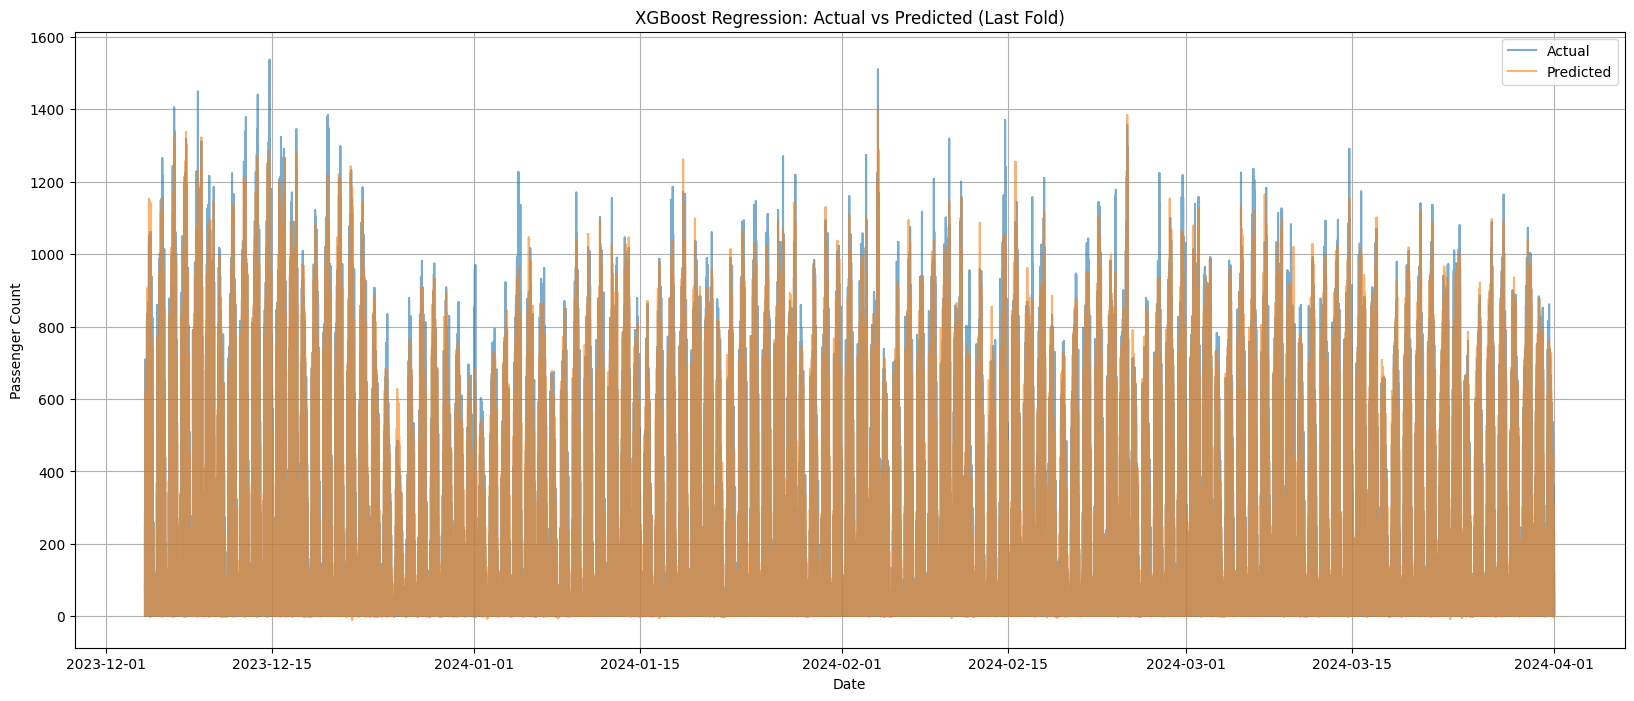

Average Mean Squared Error (MSE): 785.13
Average Root Mean Squared Error (RMSE): 27.93
Average R-squared (R2): 0.98


In [28]:
# Plotting predictions vs actual for the last fold
plt.figure(figsize=(20, 8))
plt.plot(df['transit_timestamp'].iloc[test_index], y_test, label='Actual', alpha=0.6)
plt.plot(df['transit_timestamp'].iloc[test_index], y_pred, label='Predicted', alpha=0.6)
plt.xlabel('Date')
plt.ylabel('Passenger Count')
plt.title('XGBoost Regression: Actual vs Predicted (Last Fold)')
plt.legend()
plt.grid(True)
plt.show()

# Print average metrics across all folds
print(f'Average Mean Squared Error (MSE): {np.mean(mse_list):.2f}')
print(f'Average Root Mean Squared Error (RMSE): {np.mean(rmse_list):.2f}')
print(f'Average R-squared (R2): {np.mean(r2_list):.2f}')

In [32]:
mean_passenger_count = df['passenger_count'].mean()
std_passenger_count = df['passenger_count'].std()
median_passenger_count = df['passenger_count'].median()

print(f"Mean Passenger Count: {mean_passenger_count:.2f}")
print(f"Standard Deviation of Passenger Count: {std_passenger_count:.2f}")
print(f"Median Passenger Count: {median_passenger_count:.2f}")

# RMSE value
rmse = np.mean(rmse_list)

# Relative RMSE
relative_rmse_mean = (rmse / mean_passenger_count) * 100
relative_rmse_median = (rmse / median_passenger_count) * 100



print(f"Relative RMSE (as a percentage of mean): {relative_rmse_mean:.2f}%")
print(f"Relative RMSE (as a percentage of median): {relative_rmse_median:.2f}%")


Mean Passenger Count: 152.28
Standard Deviation of Passenger Count: 182.28
Median Passenger Count: 80.00
Relative RMSE (as a percentage of mean): 18.34%
Relative RMSE (as a percentage of median): 34.92%


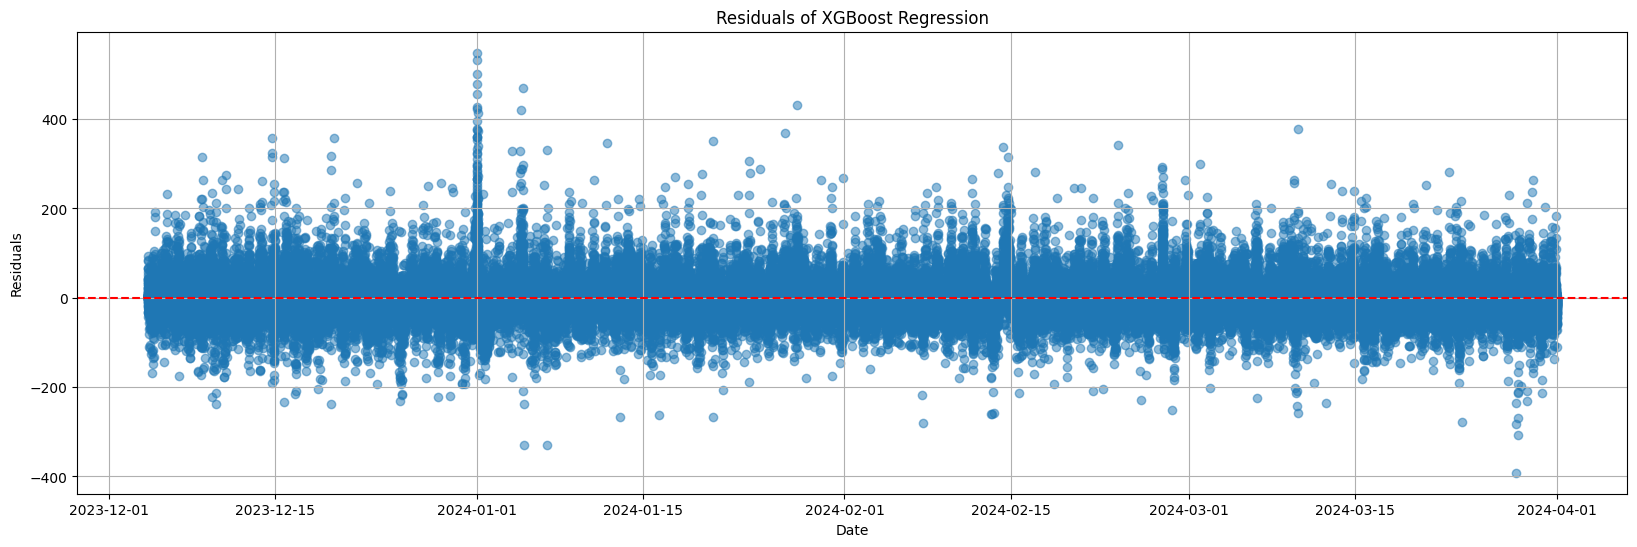

In [33]:
# Calculate residuals
residuals = y_test - y_pred

# Plot residuals
plt.figure(figsize=(20, 6))

plt.scatter(df['transit_timestamp'].iloc[test_index], residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.title('Residuals of XGBoost Regression')
plt.grid(True)
plt.show()


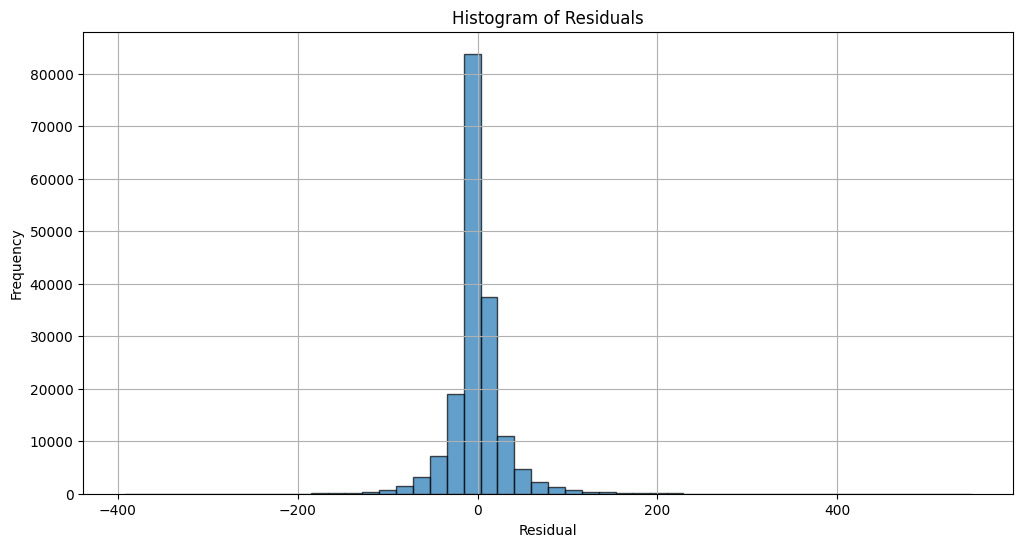

In [34]:
# Plot the histogram of the residuals
plt.figure(figsize=(12, 6))
plt.hist(residuals, bins=50, edgecolor='k', alpha=0.7)
plt.title('Histogram of Residuals')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()
